# Understanding Hired Rides in NYC
## Introduction:

Uber announced that its users in New York City could order yellow taxis through the Uber app in the future. To explore the trends for Uber and yellow taxi, we make analysis based on hired-ride trip data from Uber and NYC Yellow cab from January 2009 through June 2015, and local historical weather data.
##### The analysis is mainly broken up into 4 Parts: (Detailed analysis about each part are shown in the following Jupyter Notebook)
<br>
Data Preprocessing
<br>
Storing Data
<br>
Understanding Data
<br>
Visualizing Data

## Project Setup
All import statements needed for the project

In [1]:

import math
import numpy as np
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from scipy.stats import sem
from keplergl import KeplerGl
from math import sin, cos, sqrt, atan2, radians
import geopandas as gpd
import re
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

## Part 1: Data Preprocessing

### Calculating distance
Define a functin called "calculate_distance" that calculates the distance between two coordinates in kilometers

In [2]:
def calculate_distance(from_lat, from_long,to_lat,to_long):
    """Calculate the distance bewteen two coordinates in kilometers.

    Keyword arguments:
    Inputs: 
        from_lat -- first coordinate's latitude
        from_long -- first coordinate's longitude
        to_lat -- second coordinate's latitude
        to_long -- second coordinate's longitude
    Output:
        distance -- distance between two coordinates in kilometers
    """
    
    R = 6373.0
    lat1 = radians(from_lat)
    lon1 = radians(from_long)
    lat2 = radians(to_lat)
    lon2 = radians(to_long)
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

### Processing Taxi Data

For the taxi data, we first downloaded parquet files programmingly using regular expression,requests and beautifulsoup module. Then, we constructed a sampling of 3000 rows for each month data to make the sample size consistent with the one of Uber Data. The next step is cleaning data including removing invalid data, unnecessary columns, and add a column of distance according to the coordinates. Lastly, we append data of each month to a big dataframe.
<br>

#### Invalid Data Criteria:
passenger count=0;
fare amount<=0;
distance <=0;
 coordinates out of New York box or NaN

__1. Find Urls of Taxi Data__

In [3]:
def find_taxi_csv_urls():
    """Get Urls using requests and beautifulsoup
    Keyword Arguments:
    Output:
        res -- A list contain all urls of yellow taxi montly data
    
    """
    TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
    response = requests.get(TAXI_URL)
    html = response.content
    soup = bs4.BeautifulSoup(html,'html.parser')
    w=soup.find_all("a")
    res=[]
    for i in range(len(w)):
        if w[i].text=="Yellow Taxi Trip Records":
            res.append(w[i]['href'])
    return res

__2. Download Taxi Data from 2009-01 to 2015-06__

Please Change the downloading cell into markdown to avoid redownloading.

res=find_taxi_csv_urls()
for x in res:
    #Use regular expression to extract required urls and use requests to download data
    pattern = r"(2009-\d{2}|2010-\d{2}|2011-\d{2}|2012-\d{2}|2013-\d{2}|2014-\d{2}|2015-0[1-6])\.(parquet)"
    result = re.search(pattern, x)
   
    if result != None:
        response = requests.get(x, stream=True)
        title=result.groups()[0]
    with open(title+".parquet", "wb") as f:
        f.write(response.content)

__3. Clean Data from 2011 to 2015 (Location ID is provided instead of Coordinates)__

In [4]:
df2 = gpd.read_file('taxi_zones.shp')
df2 = df2.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
def find_long(ID,df2):
    """Find longitude using taxi_zones.shp corresponding to the Location ID
    Key Arguments:
    Inputs:
        ID -- Location ID
        df2 -- dataframe of taxi_zones.shp
    
    Outputs:
        long-- longitude
        np.nan-- if the coordinate is out of new york box
    """
    long=df2.iloc[ID-1].geometry.centroid.x
    if -74.242330<=long<=-73.717047:
        return long
    else:
        return np.nan
def find_lat(ID,df2):
    """Find latitude using taxi_zones.shp corresponding to the Location ID
    Key Arguments:
    Inputs:
        ID -- Location ID
        df2 -- dataframe of taxi_zones.shp 
    
    Outputs:
        lat-- latitude
        np.nan-- if the coordinate is out of new york box
    """
    lat=df2.iloc[ID-1].geometry.centroid.y
    if 40.560445<=lat<=40.908524:
        return lat
    else:
        return np.nan
def normal_from_2011(parquet_file):
    """Clean Data: Normalize column names, remove invalid rows, sampling size=3000, find coordinates and add distance
    Key Arguments:
    Inputs:
        parquet_file -- a string of parquet file's name
    
    Outputs:
        taxi_df -- dataframe with columns of datetime, coordinates of pickup&dropoff, distance, and tip amount
    
    """
    
    df = pd.read_parquet(parquet_file,engine='pyarrow')
    df = df[(df.passenger_count != 0) & (df.fare_amount > 0)]
    df.rename(columns={'tpep_pickup_datetime':'pickup_datetime'},inplace=True)    
    df.set_index(pd.to_datetime(df["pickup_datetime"]),inplace=True)
    df = df[["PULocationID", "DOLocationID","tip_amount"]]
    taxi_df=df.sample(n=3000,random_state=100)
    taxi_df = taxi_df.loc[(taxi_df['PULocationID'] < 264) & (taxi_df['PULocationID'] >= 1)]
    taxi_df = taxi_df.loc[(taxi_df['DOLocationID'] < 264) & (taxi_df['DOLocationID'] >= 1)]
    
    taxi_df["pickup_latitude"]=np.nan
    taxi_df["pickup_longitude"]=np.nan
    taxi_df["dropoff_latitude"]=np.nan
    taxi_df["dropoff_longitude"]=np.nan
    lat1 = taxi_df.apply(
        lambda row: find_lat(row["PULocationID"].astype('int'),df2),axis=1)
    long1 = taxi_df.apply(
        lambda row: find_long(row["PULocationID"].astype('int'),df2),axis=1)
    
    taxi_df["pickup_latitude"] = lat1
    taxi_df["pickup_longitude"] = long1
 
    lat2 = taxi_df.apply(
        lambda row: find_lat(row["DOLocationID"].astype('int'),df2),axis=1)
    long2 = taxi_df.apply(
    lambda row: find_long(row["DOLocationID"].astype('int'),df2),axis=1)

    
    taxi_df["dropoff_latitude"] = lat2
    taxi_df["dropoff_longitude"] = long2   
    
    add_distance = taxi_df.apply(
                 lambda row: calculate_distance(row["pickup_latitude"], row["pickup_longitude"],row["dropoff_latitude"],row["dropoff_longitude"]),
                 axis=1)
    taxi_df['distance'] = add_distance
    taxi_df = taxi_df[taxi_df.distance > 0]
    taxi_df.dropna(inplace=True)
    
    return pd.DataFrame(taxi_df, columns=["pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","tip_amount","distance"])

__4. Clean Data of 2009 and 2010 Respectively__

In [5]:
def norm_2009(file):
    """Clean Data: extract necessary columns and normalize names, remove invalid rows, sample size=3000
    Key Arguments:
    Inputs:
        file -- a string of parquet file's name
    
    Outputs:
        par -- dataframe with columns of datetime, coordinates of pickup&dropoff and tip amount
    """
    par=pd.read_parquet(file,engine='pyarrow')
    par.rename(columns={'Trip_Pickup_DateTime':'pickup_datetime'},inplace=True)
    par.set_index(pd.to_datetime(par['pickup_datetime']),inplace=True)
    par = par[(par.Passenger_Count != 0) & (par.Fare_Amt > 0)]
    par=par[['Start_Lon','Start_Lat','End_Lon','End_Lat','Tip_Amt']]
    par=par.sample(3000,random_state=100)
    par.rename(columns={'Start_Lon': 'pickup_longitude', 'Start_Lat': 'pickup_latitude','End_Lon':'dropoff_longitude','End_Lat':'dropoff_latitude','Tip_Amt':'tip_amount'},inplace=True)
    return par
def norm_2010(parquet_file): 
    """Clean Data: extract necessary columns and normalize names, remove invalid rows, sample size=3000
    Key Arguments:
    Inputs:
        parquet_file -- a string of parquet file's name
    
    Outputs:
        taxi_df -- dataframe with columns of datetime, coordinates of pickup&dropoff and tip amount
    """
    df = pd.read_parquet(parquet_file,engine='pyarrow')
    df.set_index(pd.to_datetime(df["pickup_datetime"]),inplace=True)
    df = df[(df.passenger_count != 0) & (df.fare_amount > 0)]
    df = df[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","tip_amount"]]
    taxi_df=df.sample(n=3000,random_state=100)
    return taxi_df
def normal_before_2011(file):
    """Calculate Distance: remove rows with coordinates outside of new york box and add distance
    Key Arguments:
    Inputs:
        file -- sampled dataframe 
    
    Outputs:
        taxi_df -- dataframe with columns of datetime, coordinates of pickup&dropoff, distance and tip amount
    """
    if file[:4]=="2009":
        taxi_df=norm_2009(file)
    else:
        taxi_df=norm_2010(file)
    taxi_df=taxi_df.loc[(taxi_df["pickup_latitude"]<=40.908524)&(taxi_df["pickup_latitude"]>=40.560445)&(taxi_df["dropoff_latitude"]<=40.908524)&(taxi_df["dropoff_latitude"]>=40.560445)&(taxi_df["pickup_longitude"]<=-73.717047)&(taxi_df["pickup_longitude"]>=-74.242330)&(taxi_df["dropoff_longitude"]<=-73.717047)&(taxi_df["dropoff_longitude"]>=-74.242330)].copy()
    add_distance = taxi_df.apply(
        lambda row: calculate_distance(row["pickup_latitude"], row["pickup_longitude"],row["dropoff_latitude"],row["dropoff_longitude"]),axis=1)
    taxi_df['distance'] = add_distance
    taxi_df = taxi_df[taxi_df.distance > 0]
    taxi_df.dropna(inplace = True)
    return taxi_df

In [6]:
#create a list storing all the file names of yellow taxi monthly data
res=find_taxi_csv_urls()
title=[]
for x in res:
    pattern = r"(2009-\d{2}|2010-\d{2}|2011-\d{2}|2012-\d{2}|2013-\d{2}|2014-\d{2}|2015-0[1-6])\.(parquet)"
    result = re.search(pattern, x)
   
    if result != None:
        title.append(result.groups()[0]+".parquet")
   
    

__5. Append Monthly Data to a Big Dataframe__

In [7]:
def get_and_clean_taxi_data(title):
    """Process Monthly Data and append to a single DataFrame
    Key Arguments:
    Inputs:
        file -- sampled dataframe 
    
    Outputs:
        taxi_df -- dataframe with columns of datetime, coordinates of pickup&dropoff, distance and tip amount
    """
    all_taxi_dataframes = []    
    for urls in title:
        if urls[:4] == "2009" or  urls[:4] == "2010":
            all_taxi_dataframes.append(normal_before_2011(urls))
        else:
            all_taxi_dataframes.append(normal_from_2011(urls))
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data
    
    

In [8]:
Taxi_Data=get_and_clean_taxi_data(title)

### Processing Uber Data

##### 1. Manually downloaded and stored Uber data as "uber_rides_sample.csv"

##### 2. Replace index with pickup_datetime

##### 3. Remove invalid trips
Trips outside the required coordinate box;
Trips with zero passenger count;
Trips with no fare;
Trips with no distance between dropoff and pickup

##### 4. Remove unnecessary columns
&nbsp;&nbsp;&nbsp;&nbsp;The dataset now only has 4 columns which represent longtitudes and latitudes respectively. 
##### 5. Add distance column
&nbsp;&nbsp;&nbsp;&nbsp;Implemented calculate_distance function and add distance as a new column
##### 6. Drop NaN & Normalize column names

In [9]:
def load_and_clean_uber_data(csv_file):
    """Load and clean the Uber data.

    Keyword arguments:
    Inputs: 
        csv_file -- Uber data's file name
    Output:
        uber -- cleaned dataframe with columns of pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, and distance
    """
    uber = pd.read_csv(csv_file) 
    uber.set_index(pd.to_datetime(uber['pickup_datetime']),inplace=True)
    uber.drop(["key","Unnamed: 0",'pickup_datetime'],axis=1,inplace=True)
    uber = uber[(uber.passenger_count != 0) & (uber.fare_amount > 0)]
    uber.drop(["passenger_count","fare_amount"],axis=1,inplace=True)
    uber['pickup_latitude'].apply(lambda x: float(x))
    uber['pickup_longitude'].apply(lambda x: float(x))
    uber['dropoff_latitude'].apply(lambda x: float(x))
    uber['dropoff_longitude'].apply(lambda x: float(x))
    uber=uber.loc[(uber["pickup_latitude"]<=40.908524)&(uber["pickup_latitude"]>=40.560445)&(uber["dropoff_latitude"]<=40.908524)&(uber["dropoff_latitude"]>=40.560445)&(uber["pickup_longitude"]<=-73.717047)&(uber["pickup_longitude"]>=-74.242330)&(uber["dropoff_longitude"]<=-73.717047)&(uber["dropoff_longitude"]>=-74.242330)]
    add_distance = uber.apply(
        lambda row: calculate_distance(row["pickup_latitude"], row["pickup_longitude"],row["dropoff_latitude"],row["dropoff_longitude"]),axis=1)
    uber['distance'] = add_distance
    uber = uber[uber.distance > 0]
    uber.dropna(inplace = True)
    
    return uber




In [10]:
Uber_Data=load_and_clean_uber_data("uber_rides_sample.csv")

### Processing Weather Data

For Weather Data, we manually downloaded them and stored as csv files. Then, we created two functions to manipulate hourly and daily data respectively. Moreover, within each function, we cleaned data by removing invalid data, removing unnecessary data, and transforming to appropriate column data type. After weather data processing, we got 2 dataframes. One is called Hourly_Weather_Data with index of datetime, columns of HourlyPrecipitation and HourlyWindSpeed. Another is called Daily_Weather_Data with index of datetime, columns of DailyAverageWindSpeed and DailyPrecipitation.

##### 1. Clean hourly weather data
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Extract only useful columns: "DATE","HourlyPrecipitation",and "HourlyWindSpeed"
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Replace "T" with 0 since it indicates trace amount of precipitation
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Convert HourlyPrecipitation data into numeric type since there are some wrongly denoted data such as "0.12s"
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Convert DATE to datetime type and replace the index with it
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Group the data into hourly data using resample('60min').mean() in pandas
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Construct cleaned dataframe "Hourly_Weather_Data" with index of DATE, columns of HourlyPrecipitation and HourlyWindSpeed

In [11]:
def clean_month_weather_data_hourly(csv_file):
    """Process and Clean Hourly Weather Data
    Key Arguments:
    Inputs:
        csv_file -- string of the name of weather file
    Outputs:
        weather -- Dataframe with columns of datetime, hourly precipitaion, and hourly wind speed
    
    """
    weather = pd.read_csv(csv_file,low_memory=False)
    weather = weather[["DATE","HourlyPrecipitation","HourlyWindSpeed"]]
    weather.replace(to_replace='T',value=0,inplace=True)
    weather['HourlyPrecipitation']=pd.to_numeric(weather['HourlyPrecipitation'],errors='coerce')
    weather.set_index(pd.to_datetime(weather["DATE"]),inplace=True)
    weather=weather.resample('60min').mean()
    weather = weather[["HourlyPrecipitation","HourlyWindSpeed"]]
    return weather

##### 2. Clean daily weather data
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  For data from 2009 to 2011, daily data is missing, so we calculate daily data from hourly data:
<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Take the mean value for windspeed and take the sum for precipitation*
<br>
&nbsp;&nbsp;&nbsp;&nbsp; *  Replace "T" with 0 since it indicates trace amount of precipitation

In [12]:
def clean_month_weather_data_daily(csv_file):
    """Process and Clean Daily Weather Data
    Key Arguments:
    Inputs:
        csv_file -- string of the name of weather file
    Outputs:
        weather -- Dataframe with columns of date, hourly precipitaion, and hourly wind speed
    
    """

    weather=pd.read_csv(csv_file,low_memory=False)
    weather=weather[["DATE","DailyAverageWindSpeed","DailyPrecipitation","HourlyPrecipitation","HourlyWindSpeed"]]
    weather.replace(to_replace='T',value=0,inplace=True)
    if int(csv_file[:4])<2012:
        weather=weather[["DATE","HourlyPrecipitation","HourlyWindSpeed"]]
        weather.set_index(pd.to_datetime(weather['DATE']),inplace=True)
        weather["HourlyPrecipitation"]=pd.to_numeric(weather["HourlyPrecipitation"])
        precipitation=weather[["DATE","HourlyPrecipitation"]].copy()
        precipitation.dropna(inplace=True)
        wind=weather[["DATE","HourlyWindSpeed"]].copy()
        wind.dropna(inplace=True)
        b=precipitation.HourlyPrecipitation.resample('D').sum()
        a=wind.HourlyWindSpeed.resample('D').mean()
        weather=pd.concat([a,b],axis=1)
        weather.rename(columns={'HourlyWindSpeed': 'DailyAverageWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'}, inplace=True)
    else:
        weather.set_index(pd.to_datetime(weather['DATE']).dt.date,inplace=True)
        weather.index = pd.to_datetime(weather.index)
        weather["DailyPrecipitation"]=pd.to_numeric(weather["DailyPrecipitation"])
        weather=weather[["DailyAverageWindSpeed","DailyPrecipitation"]]
        weather.dropna(subset=["DailyAverageWindSpeed","DailyPrecipitation"],inplace=True)
    return weather


##### 3. Construct Hourly and Daily Dataframes

In [13]:
def load_and_clean_weather_data():
    """Process all weather data and produce two dataframes
    Key Arguments:
    Outputs:
        hourly_data -- Dataframe with columns of datetime, hourly precipitaion, and hourly wind speed
        daily_data -- Dataframe with columns of date, hourly precipitaion, and hourly wind speed    
    """

    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = ["2009_weather.csv","2010_weather.csv","2011_weather.csv","2012_weather.csv","2013_weather.csv","2014_weather.csv","2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data


In [14]:
Hourly_Weather_Data, Daily_Weather_Data = load_and_clean_weather_data()

## Part 2: Storing Cleaned Data

We use SQL statement to create 4 tables to store Yellow Taxi Data, Uber Data, Hourly Weather Data and Daily Weather Data. Then, we use pandas to insert data into tables, and the results are shown in dataframes.

In [15]:
engine = db.create_engine(f"sqlite:///project.db", echo=False)

In [16]:

HOURLY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS Hourly_Weather (
        id INTEGER PRIMARY KEY,
        date DATETIME,
        hourlyprecipitation FLOAT,
        hourlywindspeed FLOAT
    )
"""

DAILY_WEATHER_SCHEMA = """
    CREATE TABLE IF NOT EXISTS Daily_Weather (
        id INTEGER PRIMARY KEY,
        date DATE,
        dailyaveragewindspeed FLOAT,
        dailyprecipitation FLOAT
    )
"""

TAXI_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS Taxi_Trips (
        id INTEGER PRIMARY KEY,
        pickup_datetime DATETIME,
        pickup_longitude FLOAT,
        pickup_latitude FLOAT,
        dropoff_longitude FLOAT,
        dropoff_latitude FLOAT,
        tip_amount FLOAT,
        distance FLOAT
    )
"""

UBER_TRIPS_SCHEMA = """
    CREATE TABLE IF NOT EXISTS Uber_Trips(
        id INTEGER PRIMARY KEY,
        pickup_datetime DATETIME,
        pickup_longitude FLOAT,
        pickup_latitude FLOAT,
        dropoff_longitude FLOAT,
        dropoff_latitude FLOAT,
        distance FLOAT
    )
"""

In [17]:
# create that required schema.sql file
with open('schema.sql', "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [18]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

We use to_sql( ) from pandas to insert value in the tables that we created above

In [19]:
Uber_Data.to_sql('Uber_Trips', con = engine, if_exists = 'append')
Taxi_Data.to_sql('Taxi_Trips', con = engine, if_exists = 'append')
Hourly_Weather_Data.to_sql('Hourly_Weather', con = engine, if_exists = 'append')
Daily_Weather_Data.to_sql('Daily_Weather', con = engine, if_exists = 'append')

In [20]:
pd.read_sql_table("Uber_Trips",engine).head(5)

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,1,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1.683851
1,2,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,2.458361
2,3,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,5.037958
3,4,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,1.662205
4,5,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,4.476855


In [21]:
pd.read_sql_table("Taxi_Trips",engine).head(5)

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,tip_amount,distance
0,1,2015-01-02 03:38:23,-73.988787,40.753513,-73.996971,40.742279,1.40,1.427277
1,2,2015-01-20 21:43:05,-73.984196,40.759818,-73.989845,40.762253,1.40,0.547544
2,3,2015-01-07 18:05:40,-73.965635,40.768615,-73.954739,40.765484,1.86,0.981734
3,4,2015-01-12 20:51:35,-73.994305,40.732579,-73.961764,40.809457,4.46,8.979733
4,5,2015-01-10 11:30:36,-73.978492,40.747746,-73.959635,40.766948,0.70,2.661992


In [22]:
pd.read_sql_table("Hourly_Weather",engine).head(5)

,id,date,hourlyprecipitation,hourlywindspeed
0,1,2009-01-01 00:00:00,NaN,18.0
1,2,2009-01-01 01:00:00,NaN,18.0
2,3,2009-01-01 02:00:00,NaN,18.0
3,4,2009-01-01 03:00:00,NaN,8.0
4,5,2009-01-01 04:00:00,NaN,11.0


In [23]:
pd.read_sql_table("Daily_Weather",engine).head(5)

,id,date,dailyaveragewindspeed,dailyprecipitation
0,1,2009-01-01,11.041667,NaN
1,2,2009-01-02,6.806452,0.0
2,3,2009-01-03,9.875000,0.0
3,4,2009-01-04,7.370370,0.0
4,5,2009-01-05,6.925926,0.0


## Part 3: Understanding the Data


Query 1: Group the amount of taxi trips by the hour of datetime then order them descendingly, so the first row is the most popular hour

Query 2: Group the amount of taxi trips by the weekday of datetime then order them descendingly, so the first row is the most popular day of week

Query 3: This query is divided into two parts: union the tables of uber & taxi and use LIMIT & OFFSET to get 95% percentile (order the data by distance, get the index of 95% percentile, and only return this row by LIMIT 1 and OFFSET the index)

Query 4: This query is divided into two parts: union the tables of uber & taxi for 2009 data and use LIMIT to extract the top 10 days with ride amounts & average distance(order the data by hired trips amount descendingly, so the first row has the highest number of hired rides for 2009)

Query 5: Use left join to combine weather and hired trips data. Then we calculate the average wind speed by using avg() function. Moreover, we used strftime() and count() function to extract date and to track corresponding hired trip amounts. We ordered the data by average wind speed descendingly, so the first row is the windest day for 2014. We used LIMIT to extract the windest 10 days in 2014

Query 6:Use left join to combine weather and hired trips data. During the data processing stage, we kept all the rows of hourly weather data even the value is NaN. Thus, we choose to use the weather table as the left table because each hour should have an entry. Then, we group the joined table by hour and use count() to get the amount of trips.

In [24]:
QUERY_1 = """
    SELECT strftime ('%H',pickup_datetime) AS HOUR, count(id) AS Trip_Amount
    FROM Taxi_Trips
    GROUP BY strftime ('%H',pickup_datetime)
    ORDER BY Trip_Amount DESC
"""
QUERY_2 = """
    SELECT strftime('%w',pickup_datetime) AS WeekDay, count(strftime('%w',pickup_datetime)) as Trip_Amount
    FROM Uber_Trips
    Group By WeekDay
    ORDER BY Trip_Amount DESC
"""
QUERY_3="""
    SELECT
      distance AS '95% percentile distance'
    FROM (SELECT distance from Uber_Trips where strftime ('%Y',pickup_datetime)='2013' AND strftime ('%m',pickup_datetime)='07'
        UNION ALL
        SELECT distance from Taxi_Trips where strftime ('%Y',pickup_datetime)='2013' AND strftime ('%m',pickup_datetime)='07')
    ORDER BY distance ASC
    LIMIT 1
    OFFSET (SELECT
             COUNT(*)
            FROM(SELECT distance from Uber_Trips where strftime ('%Y',pickup_datetime)='2013' AND strftime ('%m',pickup_datetime)='07'
        UNION ALL
        SELECT distance from Taxi_Trips where strftime ('%Y',pickup_datetime)='2013' AND strftime ('%m',pickup_datetime)='07')
          ) * 95 / 100 - 1;
"""
QUERY_4 = """
    SELECT strftime('%Y-%m-%d',pickup_datetime) AS Day, count(strftime('%d',pickup_datetime)) as Trip_Amount, sum(distance)/count(strftime('%d',pickup_datetime)) as Avg_Distance
    FROM (SELECT distance,pickup_datetime from Uber_Trips where strftime ('%Y',pickup_datetime)='2009'
            UNION ALL
        SELECT distance,pickup_datetime from Taxi_Trips where strftime ('%Y',pickup_datetime)='2009')
    Group By Day
    Order By Trip_Amount DESC
    LIMIT 10
"""
QUERY_5 = """
    SELECT strftime('%Y-%m-%d',Hourly_Weather.date) as Day,avg(hourlywindspeed) as Wind_Speed,count(tbl.Time) as Trip_Amount
    FROM Hourly_Weather 
    LEFT JOIN (SELECT strftime('%Y-%m-%d',pickup_datetime) as Time from Uber_Trips where strftime ('%Y',pickup_datetime)='2014'
                    UNION ALL
            SELECT strftime('%Y-%m-%d',pickup_datetime) as Time from Taxi_Trips where strftime ('%Y',pickup_datetime)='2014') AS tbl ON strftime('%Y-%m-%d',Hourly_Weather.date) = tbl.Time
        
    WHERE strftime ('%Y',Hourly_Weather.date)='2014'
    Group by Day
    Order By Wind_Speed DESC
    LIMIT 10   
"""
QUERY_6="""
    Select strftime('%Y-%m-%d %H',Hourly_Weather.date) AS Hour_in_Date,Hourly_Weather.hourlyprecipitation AS Precipitation,Hourly_Weather.hourlywindspeed AS SustainedWindSpeed,count(tbl.pickup_datetime) AS Trip_Amount
    FROM Hourly_Weather
    left join (SELECT pickup_datetime,distance from Uber_Trips WHERE pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-11-06 00:00:00'
            UNION ALL
            SELECT pickup_datetime,distance from Taxi_Trips where pickup_datetime BETWEEN '2012-10-22 00:00:00' AND '2012-11-06 00:00:00')AS tbl
    on strftime('%Y-%m-%d %H',tbl.pickup_datetime)= strftime('%Y-%m-%d %H',Hourly_Weather.date)
    where Hourly_Weather.date BETWEEN '2012-10-22 00:00:00' AND '2012-11-06 00:00:00'
    GROUP BY strftime('%Y-%m-%d %H',Hourly_Weather.date)
"""

In [25]:
with open("most_popular_hour_taxi.sql", "w") as f:
    f.write(QUERY_1)
with open("most_popular_weekday.sql", "w") as f:
    f.write(QUERY_2)
with open("95%_percentile_distance_2013_07.sql", "w") as f:
    f.write(QUERY_3)
with open("2009_top10_most_ride.sql", "w") as f:
    f.write(QUERY_4)
with open("2014_top10_windest_rides.sql", "w") as f:
    f.write(QUERY_5)
with open("hourly_weather_trips.sql", "w") as f:
    f.write(QUERY_6)

__Result 1: 7PM is the most popular hour to take yellow taxi with trip amount of 14082__

In [26]:
pd.read_sql_query(QUERY_1,con=engine)

,HOUR,Trip_Amount
0,19,28164
1,20,26278
2,18,26218
3,21,25202
4,22,24532
5,23,21860
6,14,21764
7,17,21748
8,13,21154
9,12,21098


__Result 2: For 01-2009 through 06-2015, Friday was the most popular to take an uber.__

In [27]:
pd.read_sql_query(QUERY_2,con=engine) 

,WeekDay,Trip_Amount
0,5,59488
1,6,58426
2,4,57914
3,3,55938
4,2,54294
5,0,51004
6,1,48560


__Result 3: 95% percentile distance is 10.136294__

In [28]:
pd.read_sql_query(QUERY_3,con=engine)

,95% percentile distance
0,10.149721


__Result 4: Top 10 days with the highest number of hired rides and average distance for 2009 are shown below__

In [29]:
pd.read_sql_query(QUERY_4,con=engine) 

,Day,Trip_Amount,Avg_Distance
0,2009-12-11,486,2.901856
1,2009-02-20,468,2.973564
2,2009-04-04,462,3.057369
3,2009-04-18,458,3.421086
4,2009-11-14,454,3.403394
5,2009-11-19,454,3.200280
6,2009-11-21,452,3.047348
7,2009-12-04,450,2.781561
8,2009-01-31,448,2.929762
9,2009-04-03,446,3.083113


__Result 5: The windiest 10 days in 2014 and corresponding hired trip amounts are shown below__

In [30]:
pd.read_sql_query(QUERY_5,con=engine)

,Day,Wind_Speed,Trip_Amount
0,2014-03-13,14.065217,20736
1,2014-01-07,13.083333,17088
2,2014-02-13,12.566667,13536
3,2014-01-02,12.350694,12672
4,2014-03-26,11.954545,17280
5,2014-12-07,11.520833,17088
6,2014-12-08,11.333333,15552
7,2014-11-02,10.826087,16992
8,2014-12-09,10.600000,15264
9,2014-03-29,10.410417,20160


__Result 6: There are 360 hours in the required time range.__

In [31]:
pd.read_sql_query(QUERY_6,con=engine)

,Hour_in_Date,Precipitation,SustainedWindSpeed,Trip_Amount
0,2012-10-22 00,0.0,7.0,16
1,2012-10-22 01,0.0,5.0,4
2,2012-10-22 02,0.0,7.0,16
3,2012-10-22 03,0.0,0.0,8
4,2012-10-22 04,0.0,0.0,0
...,...,...,...,...
355,2012-11-05 19,0.0,0.0,52
356,2012-11-05 20,0.0,3.0,60
357,2012-11-05 21,0.0,7.0,36
358,2012-11-05 22,0.0,6.0,12


## Part 4: Visualizing the Data

We use bar, line, and scatter plot for this part to create readable and interpretable visualizations based on the data from SQL tables. Furthermore, we enhanced the second plot by creating an animation of the line that represents the average distance traveled per month.

__1.  Ordered Amount of Trips of Yellow Taxi in Each Hour__
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Bar graph can convey the difference of each hour effectively

In [32]:
def plot_visual_1(data):
    """Create bar graph for amount of trips in each hour
    Key Arguments:
    Inputs:
        data -- results after executing query 1    
    """
    x_axis=[]
    y_axis=[]
    for m in data_1:
        x_axis.append(m[0])
        y_axis.append(m[1])
    fig = plt.figure(figsize =(12, 6))
    plt.bar(x_axis,y_axis,color = "lightblue")
    plt.title('Hourly Amount of Trips of Yellow Taxi From 2009 to 2015',fontsize=20,fontweight="bold")
    plt.xlabel('Hour',fontsize=15)
    plt.ylabel('Amount of Trips',fontsize=15)
    plt.show

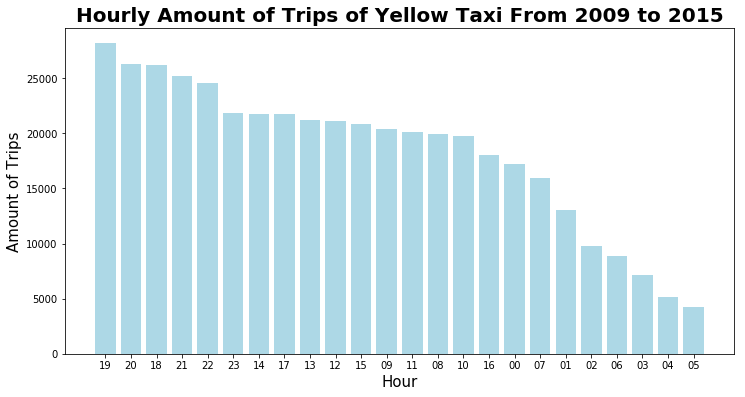

In [33]:
data_1=engine.execute(QUERY_1).fetchall()
plot_visual_1(data_1)

__2.  Average Distance Traveled Per Month & 90% Confidence Interval around the Mean__
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Since the average distance traveled in each month only appears small changes, line graph could track trivial changes over periods of time.

In [34]:
#2 plot
def get_data_for_visual_2():
    """Creating dataframes from querying the SQL table
    Key Arguments:
    Outputs:
        VQUERY_2 -- SQL Query that select average distance per month
    """
    
    VQUERY_2 = """
        SELECT strftime('%m',pickup_datetime) AS Month, sum(distance)/count(strftime('%m',pickup_datetime)) as Avg_Distance
        FROM (SELECT distance,pickup_datetime from Uber_Trips
                UNION ALL
            SELECT distance,pickup_datetime from Taxi_Trips) 
        Group By Month
    """
    return VQUERY_2
    
def plot_visual_2(avg_dis):
    """Create line graph and calculate 90% CI
    Key Arguments:
    Inputs:
        avg_dis -- dataframe after querying    
    """
    x = list(zip(*avg_dis))[0]
    y = list(zip(*avg_dis))[1]

    SE = sem(y)
    Mean = sum(y) / len(y)
    CI = (Mean-1.68*SE,Mean+1.68*SE)
    y1 = CI[0]
    y2 = CI[1]
    plt.figure(figsize=(12, 6))
    plt.plot(x,y,marker='o',markersize = "9",linewidth='4')
    plt.axhline(y = y1, color = 'grey', linestyle = '--')
    plt.axhline(y = y2, color = 'grey', linestyle = '--')
    plt.fill_between(x, y1,y2,facecolor='lightblue',alpha=0.3)
    plt.title('Average Distance Traveled per Month',size=20,fontweight="bold")
    plt.xlabel('Month',fontsize=15)
    plt.ylabel('Average Distance',fontsize=15)

    Dot_Line = mpatches.Patch(color='lightblue', label='90% CI')
    Line = mpatches.Patch(color='lightblue', label='90% CI')
    plt.legend(handles=[Dot_Line],fontsize=15)
    plt.show()

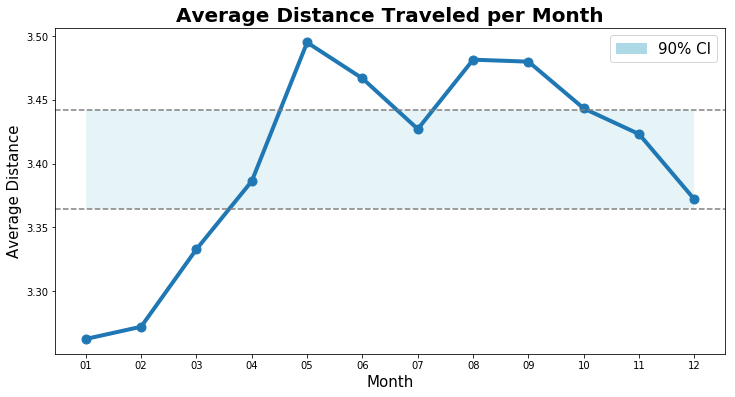

In [35]:
vdata2 = get_data_for_visual_2()
avg_dis = engine.execute(vdata2).fetchall()
plot_visual_2(avg_dis)

__3.  Amount of Trips Near 3 Airports Group By Day of the Week__
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Plotting 3 lines with dots that represent 3 different airports enables us to see the difference and trend effectively.
<br>
&nbsp;&nbsp;&nbsp;&nbsp; The coordinates of 3 airports are listed below:
<br>
* EWR = -74.198488,40.670700,-74.152311,40.708577
<br>
* LGA = -73.890082,40.766904,-73.855235,40.783024
<br>
* JFK = -73.819542,40.630891,-73.756371,40.665275


In [36]:
def get_data_for_visual_3():
    query_ewr="""
                SELECT tbl.day, count(*)
                FROM (SELECT id,strftime('%w',pickup_datetime) AS day from Uber_Trips where (dropoff_longitude BETWEEN -74.198488 AND -74.152311) AND (dropoff_latitude BETWEEN 40.670700 AND 40.708577)
                      UNION ALL
                      SELECT id,strftime('%w',pickup_datetime) AS day from Taxi_Trips where (dropoff_longitude BETWEEN -74.198488 AND -74.152311) AND (dropoff_latitude BETWEEN 40.670700 AND 40.708577)) as tbl
                GROUP BY tbl.day
            """
    query_lga="""
                SELECT tbl.day, count(*)
                FROM (SELECT id,strftime('%w',pickup_datetime) AS day from Uber_Trips where (dropoff_longitude BETWEEN -73.890082 AND -73.855235) AND (dropoff_latitude BETWEEN 40.766904 AND 40.783024)
                      UNION ALL
                      SELECT id,strftime('%w',pickup_datetime) AS day from Taxi_Trips where (dropoff_longitude BETWEEN -73.890082 AND -73.855235) AND (dropoff_latitude BETWEEN 40.766904 AND 40.783024)) as tbl
                GROUP BY tbl.day
            """
    query_jfk="""
                SELECT tbl.day, count(*)
                FROM (SELECT id,strftime('%w',pickup_datetime) AS day from Uber_Trips where (dropoff_longitude BETWEEN -73.819542 AND -73.756371) AND (dropoff_latitude BETWEEN 40.630891 AND 40.665275)
                      UNION ALL
                      SELECT id,strftime('%w',pickup_datetime) AS day from Taxi_Trips where (dropoff_longitude BETWEEN -73.819542 AND -73.756371) AND (dropoff_latitude BETWEEN 40.630891 AND 40.665275)) as tbl
                GROUP BY tbl.day
            """
    ewr=engine.execute(query_ewr).fetchall()
    lga=engine.execute(query_lga).fetchall()
    jfk=engine.execute(query_jfk).fetchall()
    return ewr,lga,jfk
 

def get_y_axis(coor):
    """Get Amount of trips from query execution result
    Key Arguments:
    Inputs:
        coor --results from query execution
    """
    y=[]
    for m in coor:
        y.append(m[1])
    return y
def plot_visual_3(ewr,lga,jfk):
    """Create line graph with dots
    Key Arguments:
    Inputs:
        ewr -- results from query of EWR data
        lga -- results from query of LGA data
        jfk -- results from query of JFK data
    """
    x=['SUN','MON','TUE','WED','THU','FRI','SAT']
    ewr= get_y_axis(ewr)     
    lga= get_y_axis(lga) 
    jfk= get_y_axis(jfk) 
    fig = plt.figure(figsize =(12, 6))
    plt.plot(x,ewr,'lightblue',label="EWR",marker='o',markersize = "9",linewidth='4')
    plt.plot(lga,'lightcoral',label="LGA",marker='o',markersize = "9",linewidth='4')
    plt.plot(jfk,'lightseagreen',label="JFK",marker='o',markersize = "9",linewidth='4')
    plt.title('Amount of Trips Near New York Airports',size=20,fontweight="bold")
    plt.xlabel('Day of Week',fontsize=15)
    plt.ylabel('Amount of Trips',fontsize=15)
    plt.legend()
    plt.show()

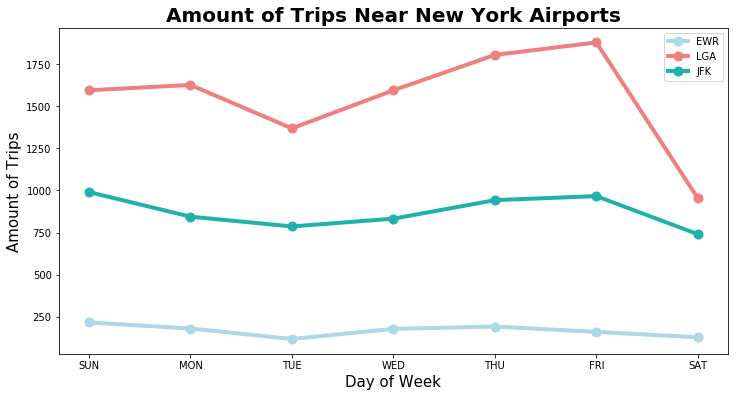

In [37]:
ewr,lga,jfk=get_data_for_visual_3()
plot_visual_3(ewr,lga,jfk)

__4. Heatmap of all hired trips over a map of the area__
* __In case the HeatMap does not show, screen shots are attached in the repo__ 

In [38]:
def get_data_for_visual_4():
    """Creating dataframes from querying the SQL table
    Key Arguments:
    Outputs:
        VQUERY_4 -- SQL Query that select all hired trips' coordinates (latitudes & longitudes)
    """
    
    VQUERY_4 = """
        SELECT pickup_latitude AS Latitude, pickup_longitude AS Longitude
        FROM (SELECT pickup_latitude,pickup_longitude,pickup_datetime from Uber_Trips
                UNION ALL
            SELECT pickup_latitude,pickup_longitude,pickup_datetime from Taxi_Trips)
    """
    return VQUERY_4
    
def plot_visual_4(HM):
    """Create heatmap of all hired trips over a map of the area
    Key Arguments:
    Inputs:
        HM -- dataframe after querying    
    """
    Lat = list(zip(*HM))[0]
    Long = list(zip(*HM))[1]
    Trips = [1]*len(Lat)
    HeatM = pd.DataFrame()
    HeatM['Latitude'] = Lat
    HeatM['Longitude'] = Long
    HeatM['Trips'] = Trips

    Heatmap=KeplerGl(height=500,width = 800,maptype="heatmap")
    Heatmap.add_data(data=HeatM,name='New York City Hired Trips')
    return Heatmap

In [39]:
vdata4 = get_data_for_visual_4()
HM = engine.execute(vdata4).fetchall()
plot_visual_4(HM)  

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York City Hired Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…

__5.  Scatter Plot of Tip Amount VS. Distance__
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Remove the outliers whose distance are greater than 20km and tip amount are greater than 20.
<br>
&nbsp;&nbsp;&nbsp;&nbsp; From the plot, we can see that there is a positive linear relationship between distance and tip.

In [40]:
def get_data_for_visual_5():
    query_taxi="""
    SELECT tip_amount,distance
    FROM Taxi_Trips
    WHERE tip_amount IS NOT NULL AND tip_amount !=0
    """
    return query_taxi
def plot_visual_5(taxi):
    """Create scatter plot
    Key Arguments:
    Inputs:
        taxi -- results from query of taxi tip amount and distance
    """
    taxi_x=[]#distance--- m[1]
    taxi_y=[]#tip---m[0]
    for m in taxi:
        if m[0]>=20 or m[1]>20:
            pass
        else:
            taxi_y.append(m[0])
            taxi_x.append(m[1])
    fig = plt.figure(figsize =(12, 6))
    plt.scatter(taxi_x, taxi_y,s=10)
    plt.title('Yellow Taxi Tip Amount VS Distance',size=20,fontweight="bold")
    plt.xlabel('Distance',fontsize=15)
    plt.ylabel('Tip Amount',fontsize=15)
    plt.show()

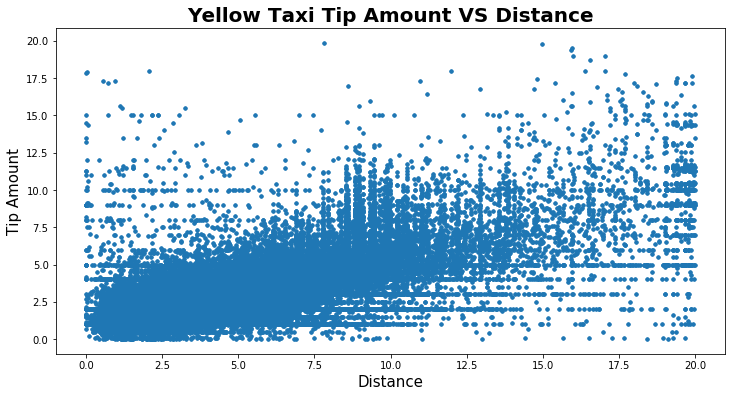

In [41]:
query_taxi=get_data_for_visual_5()
taxi=engine.execute(query_taxi).fetchall()
plot_visual_5(taxi)

__6.  Scatter Plot of Tip Amount VS. Hourly Precipitation__
<br>
&nbsp;&nbsp;&nbsp;&nbsp; Remove the outliers whose precipitation is greater than 0.5 and tip amount is greater than 10.
<br>
&nbsp;&nbsp;&nbsp;&nbsp; From the plot, we can see that there is not a strong relationship between precipitation and tip amount.

In [42]:
def get_data_for_visual_6():

    query_tip="""
                SELECT strftime('%Y-%m-%d %H',pickup_datetime) as date,tip_amount
                FROM Taxi_Trips
                WHERE tip_amount IS NOT NULL AND tip_amount !=0
            """
    query_precipitaion="""
                SELECT strftime('%Y-%m-%d %H',date) as date,hourlyprecipitation
                FROM Hourly_Weather
                WHERE hourlyprecipitation IS NOT NULL
            """
    return query_tip,query_precipitaion
def plot_visual_6(query_tip,query_precipitaion):
    """Create scatter plot for tip and precipitation
    Key Arguments:
    Inputs:
        query_tip -- SQL statement to extract tip data
        query_precipitation -- SQL statement to extract precipitation data
    """
    tip = pd.read_sql_query(query_tip, con=engine)
    precipitation=pd.read_sql_query(query_precipitaion, con=engine)
    tip_precipitation=tip.merge(precipitation)
    fig = plt.figure(figsize =(12, 6))
    plt.scatter(tip_precipitation.hourlyprecipitation,tip_precipitation.tip_amount,s=10)
    plt.xlim([0, 0.5])
    plt.ylim([0, 10])
    plt.title('Yellow Taxi Tip Amount VS Precipitation',size=20,fontweight="bold")
    plt.xlabel('Precipitation',fontsize=15)
    plt.ylabel('Tip Amount',fontsize=15)
    plt.show()

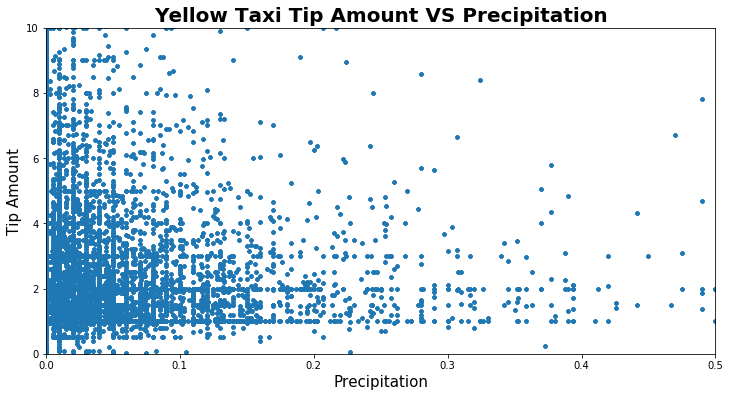

In [43]:
query_tip,query_precipitaion=get_data_for_visual_6()
plot_visual_6(query_tip,query_precipitaion)

### Extra: Animated Line Graph for Visualization2

<IPython.core.display.Javascript object>


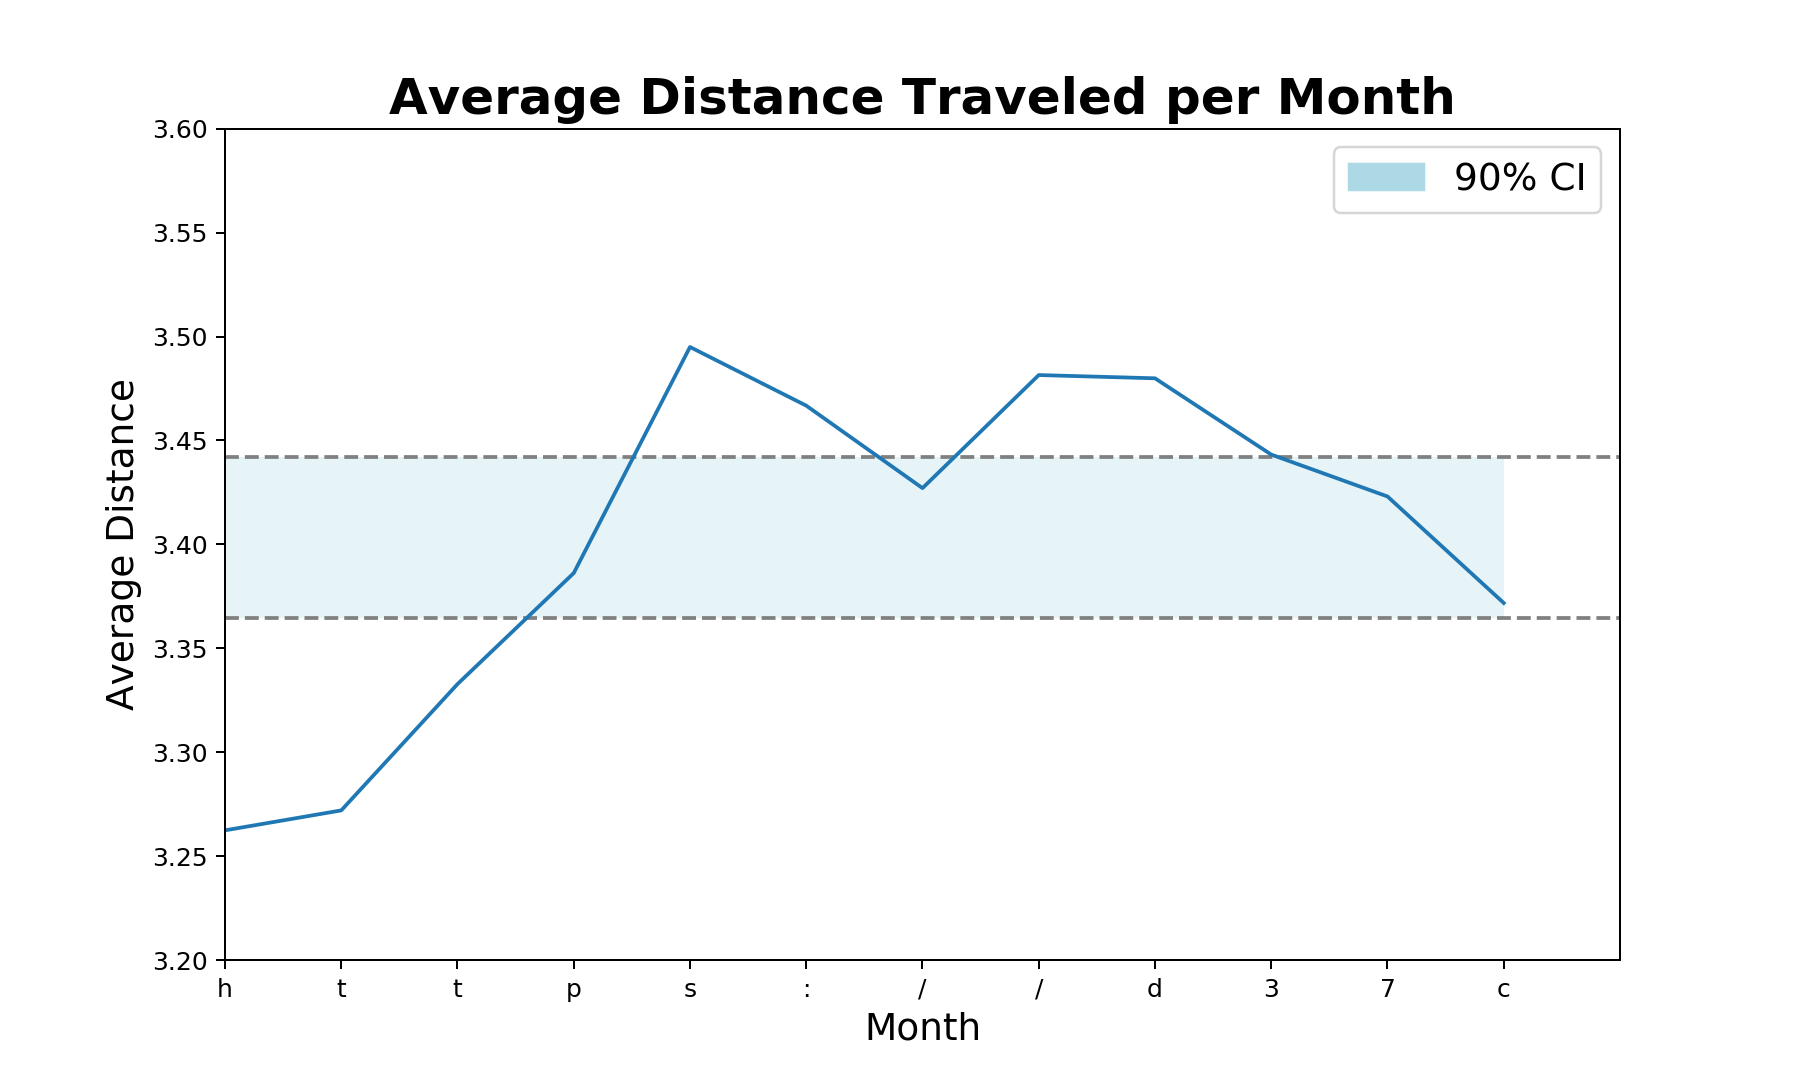

In [44]:
%matplotlib notebook
%matplotlib notebook

x_data = []
y_data = []
fig,ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0,12)
ax.set_ylim(3.2,3.6)
plt.xticks(range(0,12), x)

x = list(zip(*avg_dis))[0]
y = list(zip(*avg_dis))[1]
SE = sem(y)
Mean = sum(y) / len(y)
CI = (Mean-1.68*SE,Mean+1.68*SE)
y1 = CI[0]
y2 = CI[1]

plt.axhline(y = y1, color = 'grey', linestyle = '--')
plt.axhline(y = y2, color = 'grey', linestyle = '--')
plt.fill_between(x, y1,y2,facecolor='lightblue',alpha=0.3)
plt.title('Average Distance Traveled per Month',size=20,fontweight="bold")
plt.xlabel('Month',fontsize=15)
plt.ylabel('Average Distance',fontsize=15)

Dot_Line = mpatches.Patch(color='lightblue', label='90% CI')
Line = mpatches.Patch(color='lightblue', label='90% CI')
plt.legend(handles=[Dot_Line],fontsize=15)

line, = ax.plot(0,0)
dis = pd.DataFrame(avg_dis)
dis.columns = ['Month', 'Avg_Dis']

def animation_frame(i):
    point = dis.iloc[i,1]
    x_data.append(i)
    y_data.append(point)
    
    line.set_xdata(x_data)
    line.set_ydata(y_data)
    return line,
    
    
animation = FuncAnimation(fig, func = animation_frame,interval = 200)

plt.show()
